In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
os.chdir("/content/gdrive/My Drive/")

In [ ]:
import pandas as pd
import numpy as np
import glob
import datetime
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
import re
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score, precision_score, classification_report, recall_score, make_scorer
import math

from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler

from statistics import mean

import warnings
warnings.filterwarnings('ignore')

#Variable to dictate what data should be considered for example 2021 would denote the 2021/2022 season and 2017 would denote the 2017/2018 season.
startSeason = 2010
finishSeason = 2021
drawExcluded = False


Create a dataset that each row calculates per team rather than just home and away e.g one big dataset but if home team = liverpool HWins10 will be the number of home wins for liverpool in the last 10.

In [ ]:
#Read all datasets .csv files into one pandas dataframe
path = r'/content/gdrive/My Drive/Datasets/' # use your path
all_files = glob.glob(path + "/*.csv")
li = []
seasonCount = 0
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, encoding = "ISO-8859-1")
    li.append(df)
    seasonCount += 1

frame = pd.concat(li, axis=0, ignore_index=True)

#Filter out the betting stats columns for now
#Filter out the in games stats like fouls and cards for now also
df = frame.loc[: , :"Referee"]

#Encode the dataframe (possibly should just do separate labelencoders per string column)
le = preprocessing.LabelEncoder()
df[["HomeTeam", "AwayTeam"]] = df[["HomeTeam", "AwayTeam"]].apply(le.fit_transform)

#Keep only the seasons after the year we have provided as startSeason
if startSeason != None:
  df = df.loc[df['Year'] >= startSeason]

#Keep only the seasons before the year we have provided as finishSeason
if finishSeason != None:
  df = df.loc[df['Year'] <= finishSeason]

if drawExcluded:
  df = df.loc[df['FTR'] != "D"]

df = df.sort_values(by=["Year"], ascending=True)
individual_team_df = df.copy()

home_goals = []
away_goals = []
rivals_home = []
rivals_away = []

for row_num, row in individual_team_df.iterrows():
  #calculate the rolling sum of the last 5 games to assess home and away scoring tendencies
  individual_team_df["HGS5"] = individual_team_df.loc[individual_team_df['HomeTeam'] == row['HomeTeam']]["FTHG"].rolling(min_periods=1, window=5).sum()
  individual_team_df["AGS5"] = individual_team_df.loc[individual_team_df['AwayTeam'] == row['AwayTeam']]["FTAG"].rolling(min_periods=1, window=5).sum()
  individual_team_df["RivalsHGS5"] = individual_team_df.loc[(individual_team_df['AwayTeam'] == row['AwayTeam']) & 
                                                            (individual_team_df['HomeTeam'] == row['HomeTeam'])]["FTHG"].rolling(min_periods=1, window=5).sum()
  individual_team_df["RivalsAGS5"] = individual_team_df.loc[(individual_team_df['AwayTeam'] == row['AwayTeam']) & 
                                                            (individual_team_df['HomeTeam'] == row['HomeTeam'])]["FTAG"].rolling(min_periods=1, window=5).sum()

  home_goals.append(individual_team_df.loc[row_num,"HGS5"])
  away_goals.append(individual_team_df.loc[row_num,"AGS5"])
  rivals_home.append(individual_team_df.loc[row_num,"RivalsHGS5"])
  rivals_away.append(individual_team_df.loc[row_num,"RivalsAGS5"])

individual_team_df['HGS5'] = home_goals
individual_team_df['AGS5'] = away_goals
individual_team_df['RivalsHGS5'] = rivals_home
individual_team_df['RivalsAGS5'] = rivals_away

#Calculate the average goals scored by home and away in their last 5 games aswell as the last 5 times they played eachother
individual_team_df["AHGS5"] = individual_team_df["HGS5"]/5
individual_team_df["AAGS5"] = individual_team_df["AGS5"]/5
individual_team_df["ARivalsHGS5"] = individual_team_df["RivalsHGS5"]/5
individual_team_df["ARivalsAGS5"] = individual_team_df["RivalsAGS5"]/5

#Calculate percentage home wins, draws and away wins in the last 5 games
individual_team_df["HWins5"] = pd.get_dummies(individual_team_df["FTR"]).rolling(min_periods=1, window=5).sum()["H"]/5
individual_team_df["AWins5"] = pd.get_dummies(individual_team_df["FTR"]).rolling(min_periods=1, window=5).sum()["A"]/5
if not drawExcluded:
  individual_team_df["Draws5"] = pd.get_dummies(individual_team_df["FTR"]).rolling(min_periods=1, window=5).sum()["D"]/5

#Drop any rows that have a NaN value in it.
feature_set = individual_team_df.rename(columns={"FTR": "Result"})

if drawExcluded: 
  feature_set = feature_set[["HGS5", "AGS5","AHGS5", "AAGS5","ARivalsHGS5","ARivalsAGS5", "HWins5","AWins5", "Result"]]
else:
  feature_set = feature_set[["HGS5", "AGS5","AHGS5", "AAGS5", "ARivalsHGS5","ARivalsAGS5", "HWins5","Draws5","AWins5", "Result"]]
feature_set = feature_set.dropna()
y = np.array(feature_set.loc[:, "Result"])
X = np.array(feature_set.loc[:,:"AWins5"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

gbc = GradientBoostingClassifier()

cv_f1_score = round(mean(cross_val_score(
    gbc,
    X, y,
    scoring=make_scorer(f1_score, average='weighted'),
    cv=5)),2)

cv_accuracy = round(mean(cross_val_score(
    gbc,
    X, y,
    cv=5))*100,2)

cv_recall = round(mean(cross_val_score(
    gbc,
    X, y,
    scoring=make_scorer(recall_score, average='macro'),
    cv=5))*100,2)

cv_precision = round(mean(cross_val_score(
    gbc,
    X, y,
    scoring=make_scorer(precision_score, average='macro'),
    cv=5))*100,2)
scores_dataframe = pd.DataFrame(columns=['Classifier Name', 'F1-Scores', 'Accuracy', 'Precision', 'Recall'])
scores_dataframe.loc[0] = ["Ensemble Model",cv_f1_score,"{}%".format(cv_accuracy), cv_precision, cv_recall]

display(scores_dataframe) 
print(scores_dataframe.to_latex(index=False))


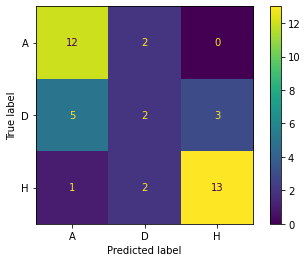

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
gbc.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(gbc, X_test, y_test)

Home = 272/324 * 100 = 91.50% accuracy when predicting home wins.

Away = 196/243 * 100 = 80.65% accurcy when predicting away wins.

Draw = 79/154 * 100 = 51.30% accuracy when predicting draws.